# SEP 775 Assignment 2

## Task1: RNN-Based Text Generation

In [33]:
import torch.nn as nn
import torch
import numpy as np
import nltk
from nltk.corpus import reuters
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

nltk.download('reuters')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\jimta\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [2]:
# Check how many documents and categories of documents Reuters corpus has
print("Reuters corpus has {} categories of documents".format(len(reuters.categories())))
print("Reuters corpus has {} documents".format(len(reuters.fileids())))

Reuters corpus has 90 categories of documents
Reuters corpus has 10788 documents


In [3]:
#raw_corpus_text = reuters.raw()

In [4]:
# Only take a subset (two categories) of the Reuters corpus to save the time for training the models
doc_list = np.array(reuters.fileids(['acq', 'money-fx']))

raw_corpus_text = "".join([reuters.raw(doc) for doc in doc_list])


In [5]:
# Define tokens for punctuation marks
def create_punct_tokens():
    """
    Generate and return a tokenized dictionary with punctuation marks as keys and tokens as values
    """
    punct_token = dict()
    punct_token['.'] = '<PERIOD>'
    punct_token[','] = '<COMMA>'
    punct_token['"'] = 'DOUBLE_QUOTE'
    punct_token[';'] = '<SEMICOLON>'
    punct_token['!'] = 'EXCLAIMATION_MARK'
    punct_token['?'] = 'QUESTION_MARK'
    punct_token['('] = 'LEFT_BRACKET'
    punct_token[')'] = 'RIGHT_BRACKET'
    punct_token['-'] = '<DASH>'
    punct_token['&'] = '<AND>'
    punct_token['\n'] = 'NEW_LINE_CHAR'
    return punct_token

In [6]:
tokens = create_punct_tokens()
tokens.items()

dict_items([('.', '<PERIOD>'), (',', '<COMMA>'), ('"', 'DOUBLE_QUOTE'), (';', '<SEMICOLON>'), ('!', 'EXCLAIMATION_MARK'), ('?', 'QUESTION_MARK'), ('(', 'LEFT_BRACKET'), (')', 'RIGHT_BRACKET'), ('-', '<DASH>'), ('&', '<AND>'), ('\n', 'NEW_LINE_CHAR')])

In [7]:
def create_vocab_lookup_table(corpus):
    """
    Function to generate lookup tables for vocabulary
    
    Parameters:
    corpus: The corpus text split into words
    
    Output:
    A tuple of dictionaries (word_to_int, int_to_word)
    """
    word_freq = Counter(corpus)
    # Sort the words by their number of appearances in the corpus
    sorted_vocab = sorted(word_freq, key=word_freq.get, reverse=True)
    int_to_word = {idx:word for idx, word in enumerate(sorted_vocab)}
    word_to_int = {word:idx for idx, word in int_to_word.items()}
    
    # return tuple
    return (word_to_int, int_to_word)

In [8]:
def preprocess_and_save_data(raw_corpus, def_punct_tokens, vocab_lookup_table_gen):
    """
    Function to preprocess the corpus data
    
    Parameters:
    raw_corpus: The whole raw corpus text as a string
    def_punct_tokens: Function that defines the punctuations tokens
    vocab_lookup_table_gen: Funtion that generates look up table for the vocab
    
    Output:
    int_corpus: list of ints converted from the corpus
    word_to_int: dict of look up table from word to int
    int_to_word: dict of look up table from int to word
    punct_token: dict of look up table for punctuations
    """
    
    # Turn all corpus text to lower case, turn punctuations into tokens
    # and split by space 
    corpus_lower = raw_corpus.lower()
    
    punct_tokens = create_punct_tokens()
    punct_tokened_corpus = corpus_lower
    for punct, token in punct_tokens.items():
        punct_tokened_corpus = punct_tokened_corpus.replace(punct, ' {} '.format(token))
    
    corpus_splitted = punct_tokened_corpus.split()
    
    # Add a padding token into the look up table other than the vocab in case it will be needed
    # as a space holder later
    corpus_splitted.append('<PAD>')
    word_to_int, int_to_word = vocab_lookup_table_gen(corpus_splitted)
    int_corpus = [word_to_int[word] for word in corpus_splitted]
    
    return (int_corpus, word_to_int, int_to_word, punct_tokens)

In [9]:
int_corpus, word_to_int,int_to_word, punct_tokens = preprocess_and_save_data(raw_corpus_text, create_punct_tokens, 
                                                                             create_vocab_lookup_table)

In [10]:
def batch_data(num_corpus, seq_len, batch_size):
    """
    Batch the corpus text data using DataLoader
    
    Parameters:
    num_corpus: Preprocessed text corpus in form of numerical sequence
    seq_len: The sequence length of each batch
    batch_size: Size of a batch (i.e. the number of sequences in each batch)
    
    Output:
    data_loader: A DataLoader object with batched text corpus
    """

    n_batches = len(num_corpus)//batch_size
    x, y = [], []
    num_corpus = num_corpus[:n_batches*batch_size]
    
    for i in range(len(num_corpus)-seq_len):
        # Split the sequence of words into seq_len given words (x) and the next word as the target (y)
        curr_seq_end = i+seq_len        
        batch_x = num_corpus[i:curr_seq_end]
        x.append(batch_x)
        batch_y = num_corpus[curr_seq_end]
        y.append(batch_y)
    
    data = TensorDataset(torch.from_numpy(np.asarray(x)), torch.from_numpy(np.asarray(y)))
    data_loader = DataLoader(data, shuffle=True, batch_size=batch_size)
        
    return data_loader

In [11]:
class RNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, out_dim, use_lstm: bool):
        """
        Initializer function the PyTorch RNN class
        
        Paramenters:
        vocab_size: The number of input dimensions of the neural network (the size of the vocabulary)
        embedding_dim: The size of embeddings, should you choose to use them        
        hidden_dim: The size of the hidden layer outputs
        out_dim: The number of output dimensions of the neural network
        use_lstm: Boolean to decide whether to use LSTM for the hidden layer or basic RNN
        """
        super(RNN, self).__init__()
        
        # set class variables
        self.use_lstm = use_lstm
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # hidden layer, could be either basic RNN or LSTM depending on the value of argument 'use_lstm'
        if use_lstm:
            self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        else:
            self.W_e = nn.Linear(embedding_dim, hidden_dim, bias=False)
            self.W_h = nn.Linear(hidden_dim, hidden_dim)
            
        # final fully connected linear layer
        self.final_fc = nn.Linear(hidden_dim, out_dim)
    
    
    def forward(self, x, hidden):
        """
        Forward propagation of the RNN model
        x: The input to the RNN
        hidden: The hidden state to be forwarded   
        
        Output:
        out, hidden: Two Tensors, the output of the RNN and the last hidden state
        """
        
        batch_size = x.size(0)
        x=x.long()
        # embedding batch_size * seq_length * embedding_dim
        embeds = self.embedding(x)
        
        # Depending on whether to use LSTM or not
        # the forward propagation will be done differently
        if self.use_lstm:
            # go through hidden layer
            h_layer_out, last_h_state = self.lstm(embeds, hidden) 
            #print(h_layer_out.size()) # (b, seq_len, hidden_dim)
            #print(len(last_h_state),last_h_state[0].size(),last_h_state[1].size())
            # fully connected linear layer 
            out = self.final_fc(h_layer_out)
            # reshaping output to batch_size * seq_length * out_dim
            #print(out.size())
            out = out.view(batch_size, -1, self.out_dim)
            # return the last batch
            out = out[:, -1]
        else:
            # go through hidden layer
            seq_len = embeds.size()[1]
            last_h_state = hidden
            for i in range(seq_len):
                W_e_prod = self.W_e(embeds[:,i])
                W_h_prod = self.W_h(last_h_state)
                #print(W_e_prod.size())
                #print(W_h_prod.size())
                last_h_state = torch.sigmoid(torch.add(W_e_prod, W_h_prod))
            
            # fully connected linear layer 
            out = self.final_fc(last_h_state)
            
        return out, last_h_state
    
    
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of LSTM/basic RNN with zero weights
        
        Parameters:
        batch_size: The batch_size of the hidden state
        
        Output:
        hidden: a hidden state of dims (n_layers, batch_size, hidden_dim)
        '''
        if self.use_lstm:
            # When using LSTM for hidden layer
            # create 2 new zero tensors of size 1 * batch_size * hidden_dim
            # Assuming the LSTM we are using only have n_layer=1
            weights = next(self.parameters()).data
            #print(type(weights), weights.size())
            hidden = (weights.new(1, batch_size, self.hidden_dim).zero_(),
                      weights.new(1, batch_size, self.hidden_dim).zero_())
        else:
            # When using basic RNN hidden layer
            # create only 1 new zero tensor of batch_size * hidden_dim
            return torch.zeros(batch_size, self.hidden_dim)
        
        return hidden

In [12]:
def forward_back_prop(rnn, optimizer, criterion, inputs, targets, hidden):
    """
    Function to forward and backward propagate the RNN model
    
    Parameters
    rnn:  The rnn model that is built using The PyTorch nn.Module
    optimizer: The PyTorch optimizer which will be used to optimize the RNN model
    criterion: The PyTorch loss function which will be used 
    inputs: A batch of input to the RNN
    targets: The target (real) output for the batch of input
    hidden: The initial hidden state
    
    Output
    (loss.item(), h): The loss and the tensor of the last hidden state
    """
    # creating clones for hidden state(s) to prevent back-propagation
    # of historical states. Will be done differently depending on if using LSTM or not
    # because the initialization is different
    if rnn.use_lstm:
        h = tuple([each.data for each in hidden])
    else:
        h = hidden.detach().clone()
    
    # clear the gradients
    rnn.zero_grad()
    
    # forward pass the RNN
    output, h = rnn(inputs, h)
    #print(output[0],output.size())
    #print(targets[0],targets.size())
    # compute the loss between the prediction and the real target
    loss = criterion(output, targets.long())
    
    # backward pass, clipping gradients, and optimization
    loss.backward()
    nn.utils.clip_grad_norm_(rnn.parameters(), 5)
    optimizer.step()

    return loss.item(), h

In [13]:
def train_rnn(rnn, data_loader, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    """
    Function to train RNN using batched data
    
    Parameters
    rnn:  The RNN that is to be trained
    data_loader: A torch DataLoader object that loads data in batches
    batch_size: Size of a batch (i.e. the number of sequences in each batch)
    optimizer: The PyTorch optimizer which will be used to optimize the RNN model
    criterion: The PyTorch loss function which will be used 
    n_epochs: Number of Epochs to be run for training
    show_every_n_batches: show avg loss for every certain number of batches
    
    Output
    rnn: The trained RNN
    epoch_avg_loss: avg losses of each epoch
    """
    # lists for recording losses of each batch, during each epoch
    # and avg loss of each epoch
    batch_losses = []
    epoch_losses = []
    epoch_avg_loss = []
    
    
    rnn.train()

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(data_loader, 1):
            
            # make sure to iterate over only full batches
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)          
            # record loss
            batch_losses.append(loss)
            epoch_losses.append(loss)

            # printing loss stats
            if batch_i % show_every_n_batches == 0:
                print('Epoch: {:>4}/{:<4}  Loss: {}\n'.format(
                    epoch_i, n_epochs, np.average(batch_losses)))
                batch_losses = []
        
        epoch_avg_loss.append(np.average(epoch_losses))
        epoch_losses = []

    return rnn,epoch_avg_loss

In [14]:
# Data params
# Sequence Length
sequence_length = 5  # of words in a sequence
# Batch Size
batch_size = 128

# data loader
train_loader = batch_data(int_corpus, sequence_length, batch_size)
# defining loss functions for training
criterion = nn.CrossEntropyLoss()

Experimenting with different values for hyper-parameters (including the number of epochs, learning rate, the dimensions of hidden states)

In [24]:
# Candidate Hyper-parameters:
num_epochs = 15
embedding_dim = 200
learning_rates = np.array([0.001, 0.005, 0.01, 0.05, 0.09, 0.1])
hidden_dims = [250,300,350]

show_every_n_batches = 500
vocab_size = len(word_to_int)
output_size = vocab_size

In [25]:
# Dict to record the losses of using different values for hyper-parameters
hyper_param_loss_dict = {'learning_rate':[], 'hidden_dim':[], 'epoch':[], 'Avg_Loss':[]}
for lr in learning_rates:
    print("Training with learning rate: "+str(lr))
    hyper_param_loss_dict['learning_rate'] += [lr]*(len(hidden_dims)*num_epochs)
    for dim in hidden_dims:
        print("Training with hidden state dimension: "+str(dim))
        hyper_param_loss_dict['hidden_dim'] += [dim]*(num_epochs)
        hyper_param_loss_dict['epoch'] += list(range(num_epochs))
        # create model 
        candidate_rnn = RNN(vocab_size, embedding_dim, dim, output_size, use_lstm=False)
        # training the model
        # defining optimization function for training
        optimizer = torch.optim.Adam(candidate_rnn.parameters(), lr=lr)

        _, epoch_losses = train_rnn(candidate_rnn, train_loader, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)
        hyper_param_loss_dict['Avg_Loss'] += epoch_losses
        

Training with learning rate: 0.001
Training with hidden state dimension: 250
Training for 15 epoch(s)...
Epoch:    1/15    Loss: 5.892782183647156

Epoch:    1/15    Loss: 5.307046063423157

Epoch:    2/15    Loss: 4.866922467697764

Epoch:    2/15    Loss: 4.59913600730896

Epoch:    3/15    Loss: 4.32284198097858

Epoch:    3/15    Loss: 4.1653746600151065

Epoch:    4/15    Loss: 3.9731995333052876

Epoch:    4/15    Loss: 3.8395837602615357

Epoch:    5/15    Loss: 3.6797282037769166

Epoch:    5/15    Loss: 3.5805920677185057

Epoch:    6/15    Loss: 3.4332092019107323

Epoch:    6/15    Loss: 3.3520095620155335

Epoch:    7/15    Loss: 3.222678040945402

Epoch:    7/15    Loss: 3.1739500789642334

Epoch:    8/15    Loss: 3.0462974046435978

Epoch:    8/15    Loss: 3.0039138293266294

Epoch:    9/15    Loss: 2.8832656385793194

Epoch:    9/15    Loss: 2.861078366279602

Epoch:   10/15    Loss: 2.749885073129706

Epoch:   10/15    Loss: 2.7265340433120726

Epoch:   11/15    Loss: 2

Epoch:   15/15    Loss: 1.74020826631407

Epoch:   15/15    Loss: 1.7683720927238464

Training with learning rate: 0.01
Training with hidden state dimension: 250
Training for 15 epoch(s)...
Epoch:    1/15    Loss: 5.551445854187012

Epoch:    1/15    Loss: 5.057947745323181

Epoch:    2/15    Loss: 4.5388334444061975

Epoch:    2/15    Loss: 4.275701213359833

Epoch:    3/15    Loss: 4.00014991743163

Epoch:    3/15    Loss: 3.932304856300354

Epoch:    4/15    Loss: 3.7497345515334337

Epoch:    4/15    Loss: 3.7260545225143433

Epoch:    5/15    Loss: 3.6063370966711923

Epoch:    5/15    Loss: 3.5966612868309022

Epoch:    6/15    Loss: 3.5028117628792566

Epoch:    6/15    Loss: 3.5383919954299925

Epoch:    7/15    Loss: 3.4379405539522887

Epoch:    7/15    Loss: 3.465424479484558

Epoch:    8/15    Loss: 3.394089446985024

Epoch:    8/15    Loss: 3.448807909011841

Epoch:    9/15    Loss: 3.356193090710019

Epoch:    9/15    Loss: 3.3999118752479554

Epoch:   10/15    Loss: 3.32

Epoch:   14/15    Loss: 8.783223257064819

Epoch:   15/15    Loss: 8.701890975058863

Epoch:   15/15    Loss: 8.76587266921997

Training with learning rate: 0.09
Training with hidden state dimension: 250
Training for 15 epoch(s)...
Epoch:    1/15    Loss: 9.122331637382507

Epoch:    1/15    Loss: 11.073462259292603

Epoch:    2/15    Loss: 11.355621434739271

Epoch:    2/15    Loss: 11.138000118255615

Epoch:    3/15    Loss: 10.768823218602007

Epoch:    3/15    Loss: 11.00154409980774

Epoch:    4/15    Loss: 11.23518446668217

Epoch:    4/15    Loss: 11.21019117641449

Epoch:    5/15    Loss: 10.547713688767226

Epoch:    5/15    Loss: 10.708016806602478

Epoch:    6/15    Loss: 10.627297895926016

Epoch:    6/15    Loss: 10.828665282249451

Epoch:    7/15    Loss: 10.54500716561485

Epoch:    7/15    Loss: 10.496614663124085

Epoch:    8/15    Loss: 10.249822912250368

Epoch:    8/15    Loss: 10.34959367465973

Epoch:    9/15    Loss: 9.935550417381661

Epoch:    9/15    Loss: 10.

Epoch:   13/15    Loss: 10.469601447152122

Epoch:   13/15    Loss: 10.383438373565674

Epoch:   14/15    Loss: 10.325560243326276

Epoch:   14/15    Loss: 10.497601274490357

Epoch:   15/15    Loss: 10.357724575443791

Epoch:   15/15    Loss: 10.810566719055176



In [29]:
avg_losses_df = pd.DataFrame(hyper_param_loss_dict)

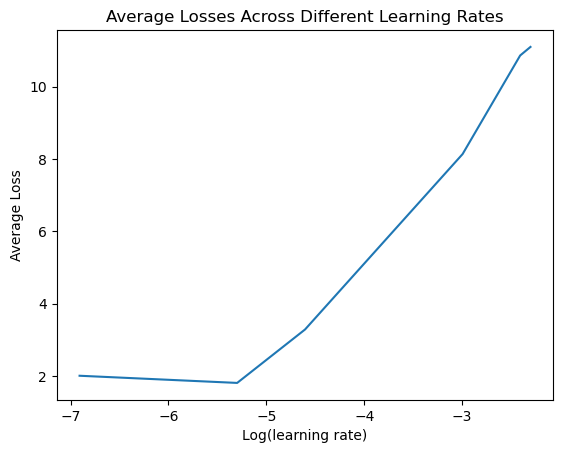

In [58]:
loss_across_lr = avg_losses_df[(avg_losses_df['epoch']==14)]
avg_losses_lr = []
for lr in learning_rates:
    avg_losses_lr.append(np.mean(loss_across_lr[loss_across_lr['learning_rate']==lr]['Avg_Loss'].values))

plt.plot(torch.log(torch.Tensor(learning_rates)), avg_losses_lr)
plt.xlabel('Log(learning rate)')
plt.ylabel('Average Loss')
plt.title('Average Losses Across Different Learning Rates')
plt.show()

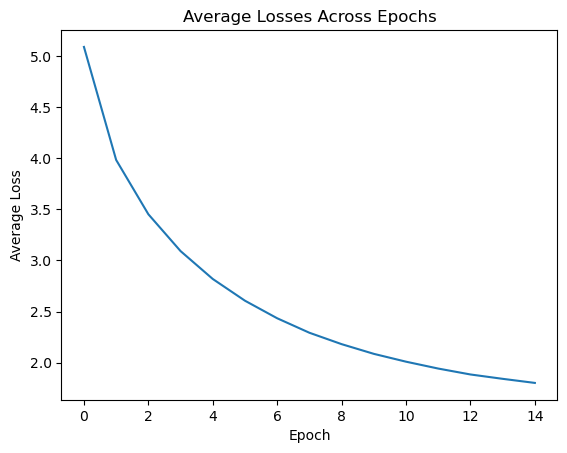

In [62]:
loss_across_epoch = avg_losses_df[(avg_losses_df['learning_rate']==0.005) & (avg_losses_df['hidden_dim']==300)]

plt.plot(loss_across_epoch['epoch'], loss_across_epoch['Avg_Loss'])
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Losses Across Epochs')
plt.show()

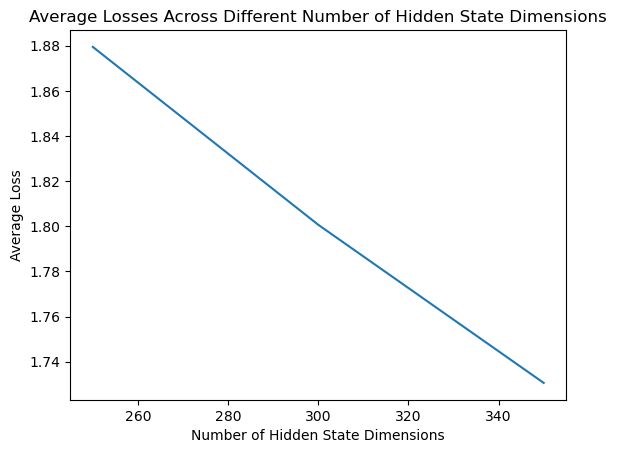

In [64]:
loss_across_hidden_dim = avg_losses_df[(avg_losses_df['learning_rate']==0.005) & (avg_losses_df['epoch']==14)]

plt.plot(loss_across_hidden_dim['hidden_dim'], loss_across_hidden_dim['Avg_Loss'])
plt.xlabel('Number of Hidden State Dimensions')
plt.ylabel('Average Loss')
plt.title('Average Losses Across Different Number of Hidden State Dimensions')
plt.show()

In [65]:
# Final selected Hyper-parameters
# Number of Epochs
num_epochs = 15
# Learning Rate
learning_rate = 0.005
# Hidden Dimension
hidden_dim = 350

# Model parameters
# Vocab size
vocab_size = len(word_to_int)
# Output size
output_size = vocab_size
# Embedding Dimension
embedding_dim = 200


# Show stats for every n number of batches
show_every_n_batches = 500

In [78]:
# create model 
rnn = RNN(vocab_size, embedding_dim, hidden_dim, output_size, use_lstm=False)

# define optimizer function used for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
# training the model
trained_basic_rnn,_ = train_rnn(rnn, train_loader, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
torch.save(trained_basic_rnn, './trained_basic_rnn.pt')
print('Model Trained and Saved')

Training for 15 epoch(s)...
Epoch:    1/15    Loss: 5.549894979476929

Epoch:    1/15    Loss: 4.881221632957459

Epoch:    2/15    Loss: 4.268676348769394

Epoch:    2/15    Loss: 3.984574646472931

Epoch:    3/15    Loss: 3.5745635058290217

Epoch:    3/15    Loss: 3.42610702419281

Epoch:    4/15    Loss: 3.162780809288526

Epoch:    4/15    Loss: 3.058818323135376

Epoch:    5/15    Loss: 2.8435083156275778

Epoch:    5/15    Loss: 2.7866042408943175

Epoch:    6/15    Loss: 2.5868459583895467

Epoch:    6/15    Loss: 2.5698769874572753

Epoch:    7/15    Loss: 2.409378786668128

Epoch:    7/15    Loss: 2.384478538751602

Epoch:    8/15    Loss: 2.2467891675739446

Epoch:    8/15    Loss: 2.250401969432831

Epoch:    9/15    Loss: 2.1198230189946674

Epoch:    9/15    Loss: 2.137388775110245

Epoch:   10/15    Loss: 2.0250413201330955

Epoch:   10/15    Loss: 2.0323149600028994

Epoch:   11/15    Loss: 1.9398344218232442

Epoch:   11/15    Loss: 1.9483222815990449

Epoch:   12/15  

In [79]:
# create model that uses LSTM
lstm_rnn = RNN(vocab_size, embedding_dim, hidden_dim, output_size, use_lstm=True)

# define optimizer function used for training
optimizer = torch.optim.Adam(lstm_rnn.parameters(), lr=learning_rate)
# training the model
trained_lstm_rnn,_ = train_rnn(lstm_rnn, train_loader, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
torch.save(trained_lstm_rnn, './trained_lstm_rnn.pt')
print('Model Trained and Saved')

Training for 15 epoch(s)...
Epoch:    1/15    Loss: 5.364768112182618

Epoch:    1/15    Loss: 4.728087137699127

Epoch:    2/15    Loss: 4.055232296992658

Epoch:    2/15    Loss: 3.803310840129852

Epoch:    3/15    Loss: 3.3655248830537783

Epoch:    3/15    Loss: 3.2241361837387084

Epoch:    4/15    Loss: 2.8824446338051963

Epoch:    4/15    Loss: 2.830773615837097

Epoch:    5/15    Loss: 2.565239668747003

Epoch:    5/15    Loss: 2.5435250153541564

Epoch:    6/15    Loss: 2.328598717777248

Epoch:    6/15    Loss: 2.3260596361160277

Epoch:    7/15    Loss: 2.1636365609357004

Epoch:    7/15    Loss: 2.1723295879364013

Epoch:    8/15    Loss: 2.0358788242191967

Epoch:    8/15    Loss: 2.0666073229312896

Epoch:    9/15    Loss: 1.920005723282143

Epoch:    9/15    Loss: 1.9449309408664703

Epoch:   10/15    Loss: 1.8416973969130248

Epoch:   10/15    Loss: 1.8879246706962585

Epoch:   11/15    Loss: 1.7672225682681322

Epoch:   11/15    Loss: 1.8239736342430115

Epoch:   12/

In [80]:
def generate(rnn, first_word_id, seq_len, int_to_word, punct_tokens, pad_value, predict_len=100):
    """
    Function to generate text using trained RNN
    
    Parameters:
    rnn: RNN model
    first_word_id: The word id to start the first prediction
    seq_len: sequence length 
    int_to_word: Dict of word id keys to numerical(int) values
    punct_tokens: Dict of puncuation tokens keys to numerical(int) values
    pad_value: The token used to pad a sequence
    predict_len: The length of text to be generated
    
    Outputs:
    gen_sentences: The generated text
    """
    rnn.eval()
    
    # create a sequence with the first_word_id
    # initialize current sequence with numpy array filled with padding value
    current_seq = np.full((1, seq_len), pad_value)
    # put the first word's id at the end of current sequence 
    current_seq[-1][-1] = first_word_id
    # list to record the predicted words 
    predicted = [int_to_word[first_word_id]]
    
    for _ in range(predict_len):
        # covert current_seq from np array to LongTensor
        current_seq = torch.LongTensor(current_seq)
        
        # initialize the hidden state
        hidden = rnn.init_hidden(current_seq.size(0))
        
        # get the output of the rnn
        output, _ = rnn(current_seq, hidden)
        
        # get probability distribution of the next word
        prob_distr = F.softmax(output, dim=1).data
         
        # use top_k(5) sampling to get the index of the next word
        top_k = 5
        # get the k highest values in the probability distribution
        # and their correponding indices
        prob_distr, top_i = prob_distr.topk(top_k)
        # turn the top_i and prob_distr tensors to np.ndarray and 
        # remove the unnecessary dimension with length 1
        top_i = top_i.numpy().squeeze()
        prob_distr = prob_distr.numpy().squeeze()
        
        # select the likely next word index with some element of randomness
        word_id = np.random.choice(top_i, p=prob_distr/prob_distr.sum())
        
        # retrieve that word from the dictionary
        word = int_to_word[word_id]
        predicted.append(word)     
        
        # the generated word becomes the next "current_seq" and continue the loop
        # roll the array to put the padding value to the end and shift the words 
        # that has been generated to the left (towards the head of the array)
        current_seq = np.roll(current_seq, -1, 1)
        current_seq[-1][-1] = word_id
    
    gen_sentences = ' '.join(predicted)
    
    # Replace punctuation tokens
    for punct, token in punct_tokens.items():
        #ending = ' ' if punct in ['\n', '(', '"'] else ''
        gen_sentences = gen_sentences.replace(' ' + token, punct)
    # Replace tailing space char following '\n' and '('
    gen_sentences = gen_sentences.replace('\n ', '\n')
    gen_sentences = gen_sentences.replace('( ', '(')
    
    return gen_sentences

In [97]:
generated_text = generate(trained_basic_rnn, word_to_int['england'], 5, int_to_word, punct_tokens, word_to_int['<PAD>'], 100)
print(generated_text)

england
said the central bank intervened to buy dollar
usx corp chairman david roderick said.
" i think we're near a daily basis," hamley said.
the dollar has nearly halved its value against major currencies, but u. s.
government securities market to arrange two billion dlrs at 10- 3/4 pct, and the
u. s. dlrs from july 1986, the bank added.
the dollar has hovered around 40 mln stg in band one at 9- 3/4 pct, the national bank


In [94]:
generated_text = generate(trained_lstm_rnn, word_to_int['england'], 5, int_to_word, punct_tokens, word_to_int['<PAD>'], 100)
print(generated_text)

england
would force the u. s. and japan will not want it to
become uncompetitive because of a lower house budget committee in parliament on indonesia 2 in the year ending march 1988, leading to a meeting of
the group of five(g- 5) industrial nations reaffirmed their willingness to
cooperate on securities repurchase pacts
the bank of england has recently
used and a news conference yesterday's drop as
as the dollar remains in a
41- day repurchase pacts
the fed is quite adequate as
